# Topic Modeling
### ... in a nutshell:

<img src="https://moj-analytical-services.github.io/NLP-guidance/LDAresults.png" alt="lda" style="width: 600px;"/>

Partially pased on [this blogpost](https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/) by Selva Prabhakaran.

In [1]:
import sys
import re, numpy as np
from pprint import pprint
import warnings

We will need to draw some plots:

In [3]:
%matplotlib inline

We again use Gensim library, but now we work with its topic modelling features.

In [4]:
# Gensim
import gensim, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [6]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gera\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


NLTK toolkit provides us with a corpus and additional tools:

In [7]:
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

In [8]:
# Import Dataset
import nltk 
nltk.download('gutenberg')
nltk.download('wordnet')

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Gera\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\gutenberg.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gera\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

Let us take Lewis Carroll's "Alice in Wonderland" and preprocess it:

In [15]:
alice = nltk.corpus.gutenberg.sents('E:/Desktop/alice.txt')

In [16]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(alice, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[alice], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
from nltk.stem import WordNetLemmatizer
wnl = WordNetLemmatizer()

def process_words(texts):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    for sent in texts:
        texts_out.append([wnl.lemmatize(token) for token in sent])
    # remove stopwords after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(alice)  # processed Text Data!

In [18]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

The topic modelling we use is Latent Dirichlet Allocation. We have to skip the details here, but you can find all the details in [the original paper](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf).

In [19]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.073*"new" + 0.040*"including" + 0.021*"site" + 0.014*"subscribe" + '
  '0.014*"includes" + 0.014*"produce" + 0.014*"newsletter" + 0.013*"one" + '
  '0.013*"little" + 0.011*"email"'),
 (1,
  '0.038*"help" + 0.038*"hear" + 0.022*"donation" + 0.019*"section" + '
  '0.015*"without" + 0.014*"tax" + 0.013*"queen" + 0.012*"day" + 0.010*"alice" '
  '+ 0.010*"number"'),
 (2,
  '0.075*"said" + 0.032*"must" + 0.026*"alice" + 0.017*"king" + '
  '0.016*"received" + 0.011*"keep" + 0.011*"unless" + 0.011*"give" + '
  '0.010*"head" + 0.010*"people"'),
 (3,
  '0.077*"gutenberg" + 0.074*"project" + 0.036*"work" + 0.036*"tm" + '
  '0.029*"foundation" + 0.024*"ebooks" + 0.020*"archive" + 0.020*"literary" + '
  '0.017*"donation" + 0.016*"information"')]


Let us see on the corpus and output model more precisely:

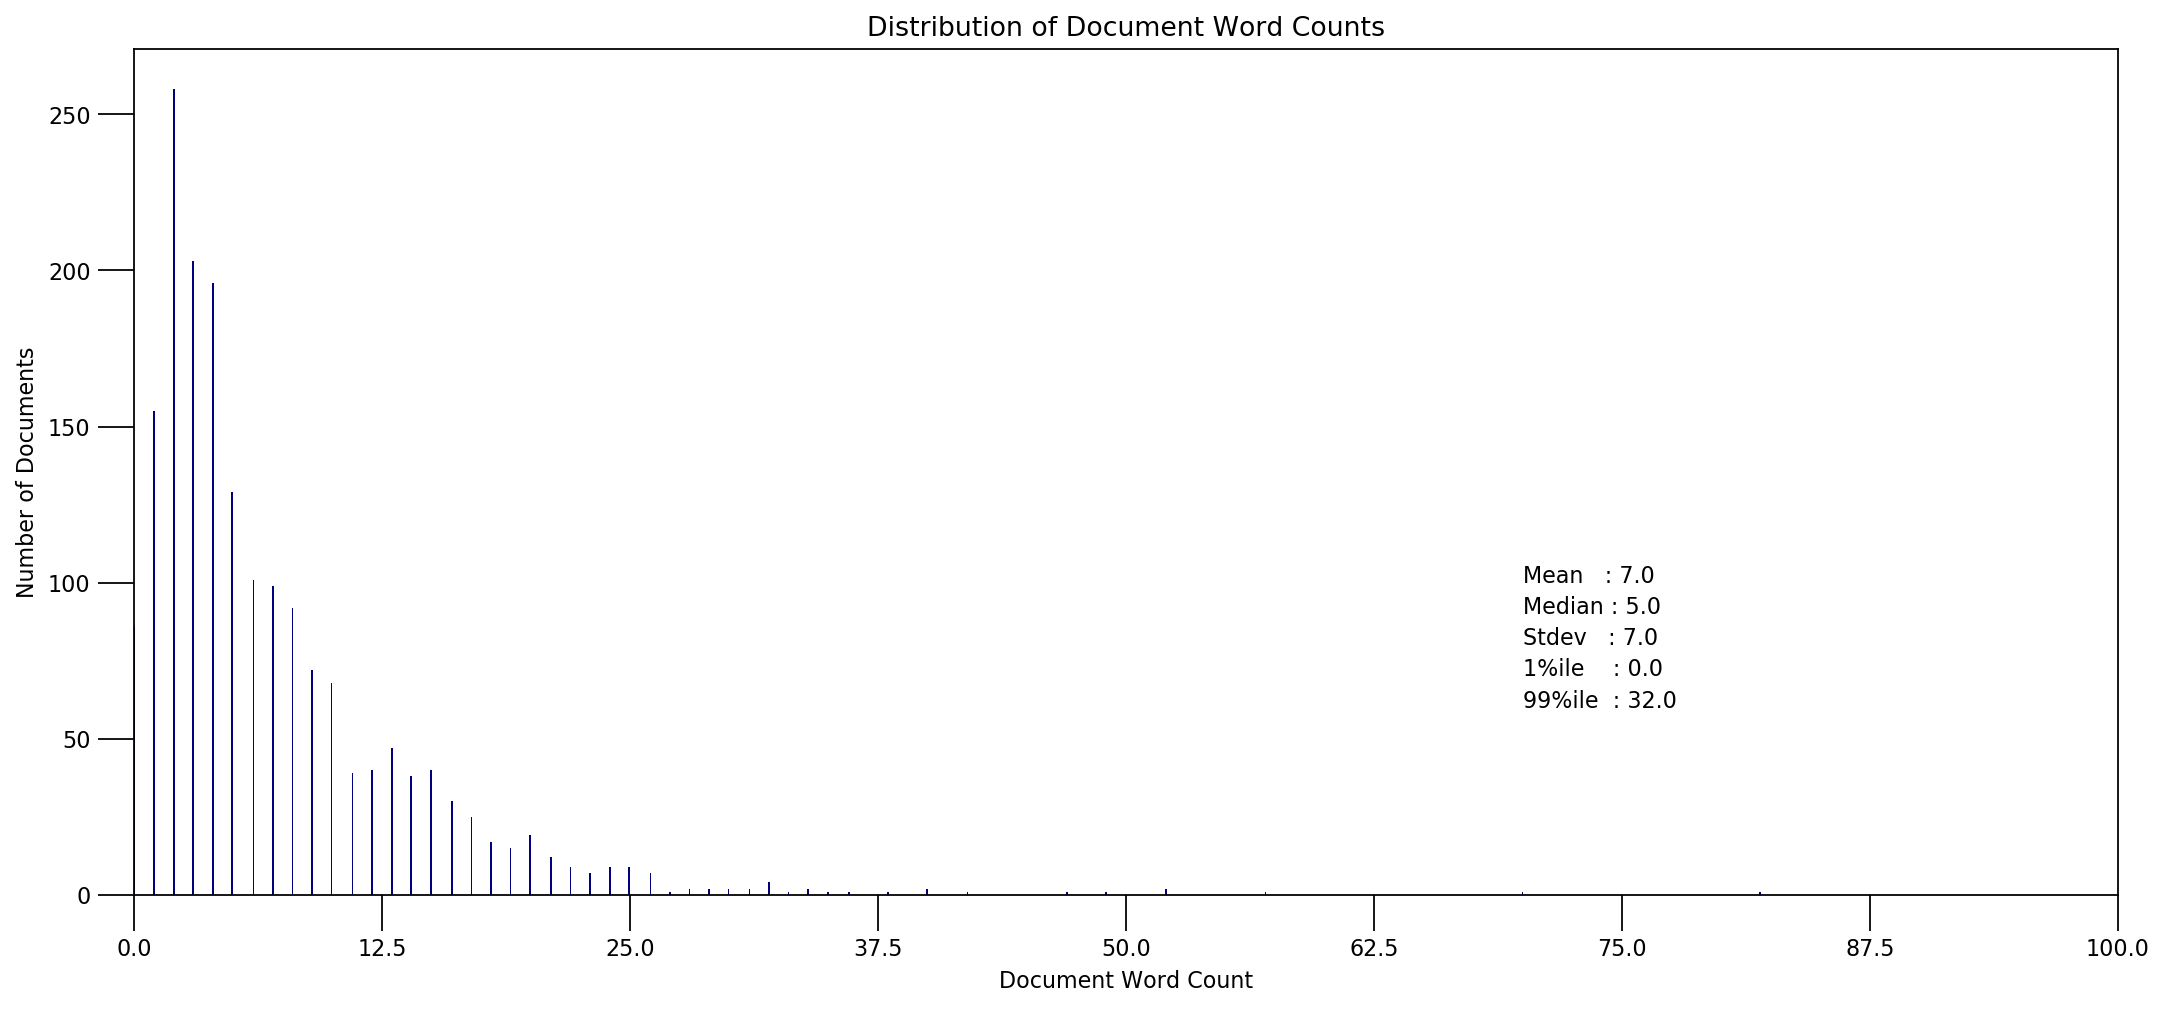

In [20]:
doc_lens = [len(d) for d in data_ready]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(70, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(70,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(70,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(70,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(70,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts')
plt.show()

In [21]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = {}
for i, topic in topics:
    if i  not in out:
        out[i] = {'word': [], 'importance': [], 'word_count': []}
    for word, weight in topic:
        out[i]["word"].append(word)
        out[i]["importance"].append(weight)
        out[i]["word_count"].append(counter[word])

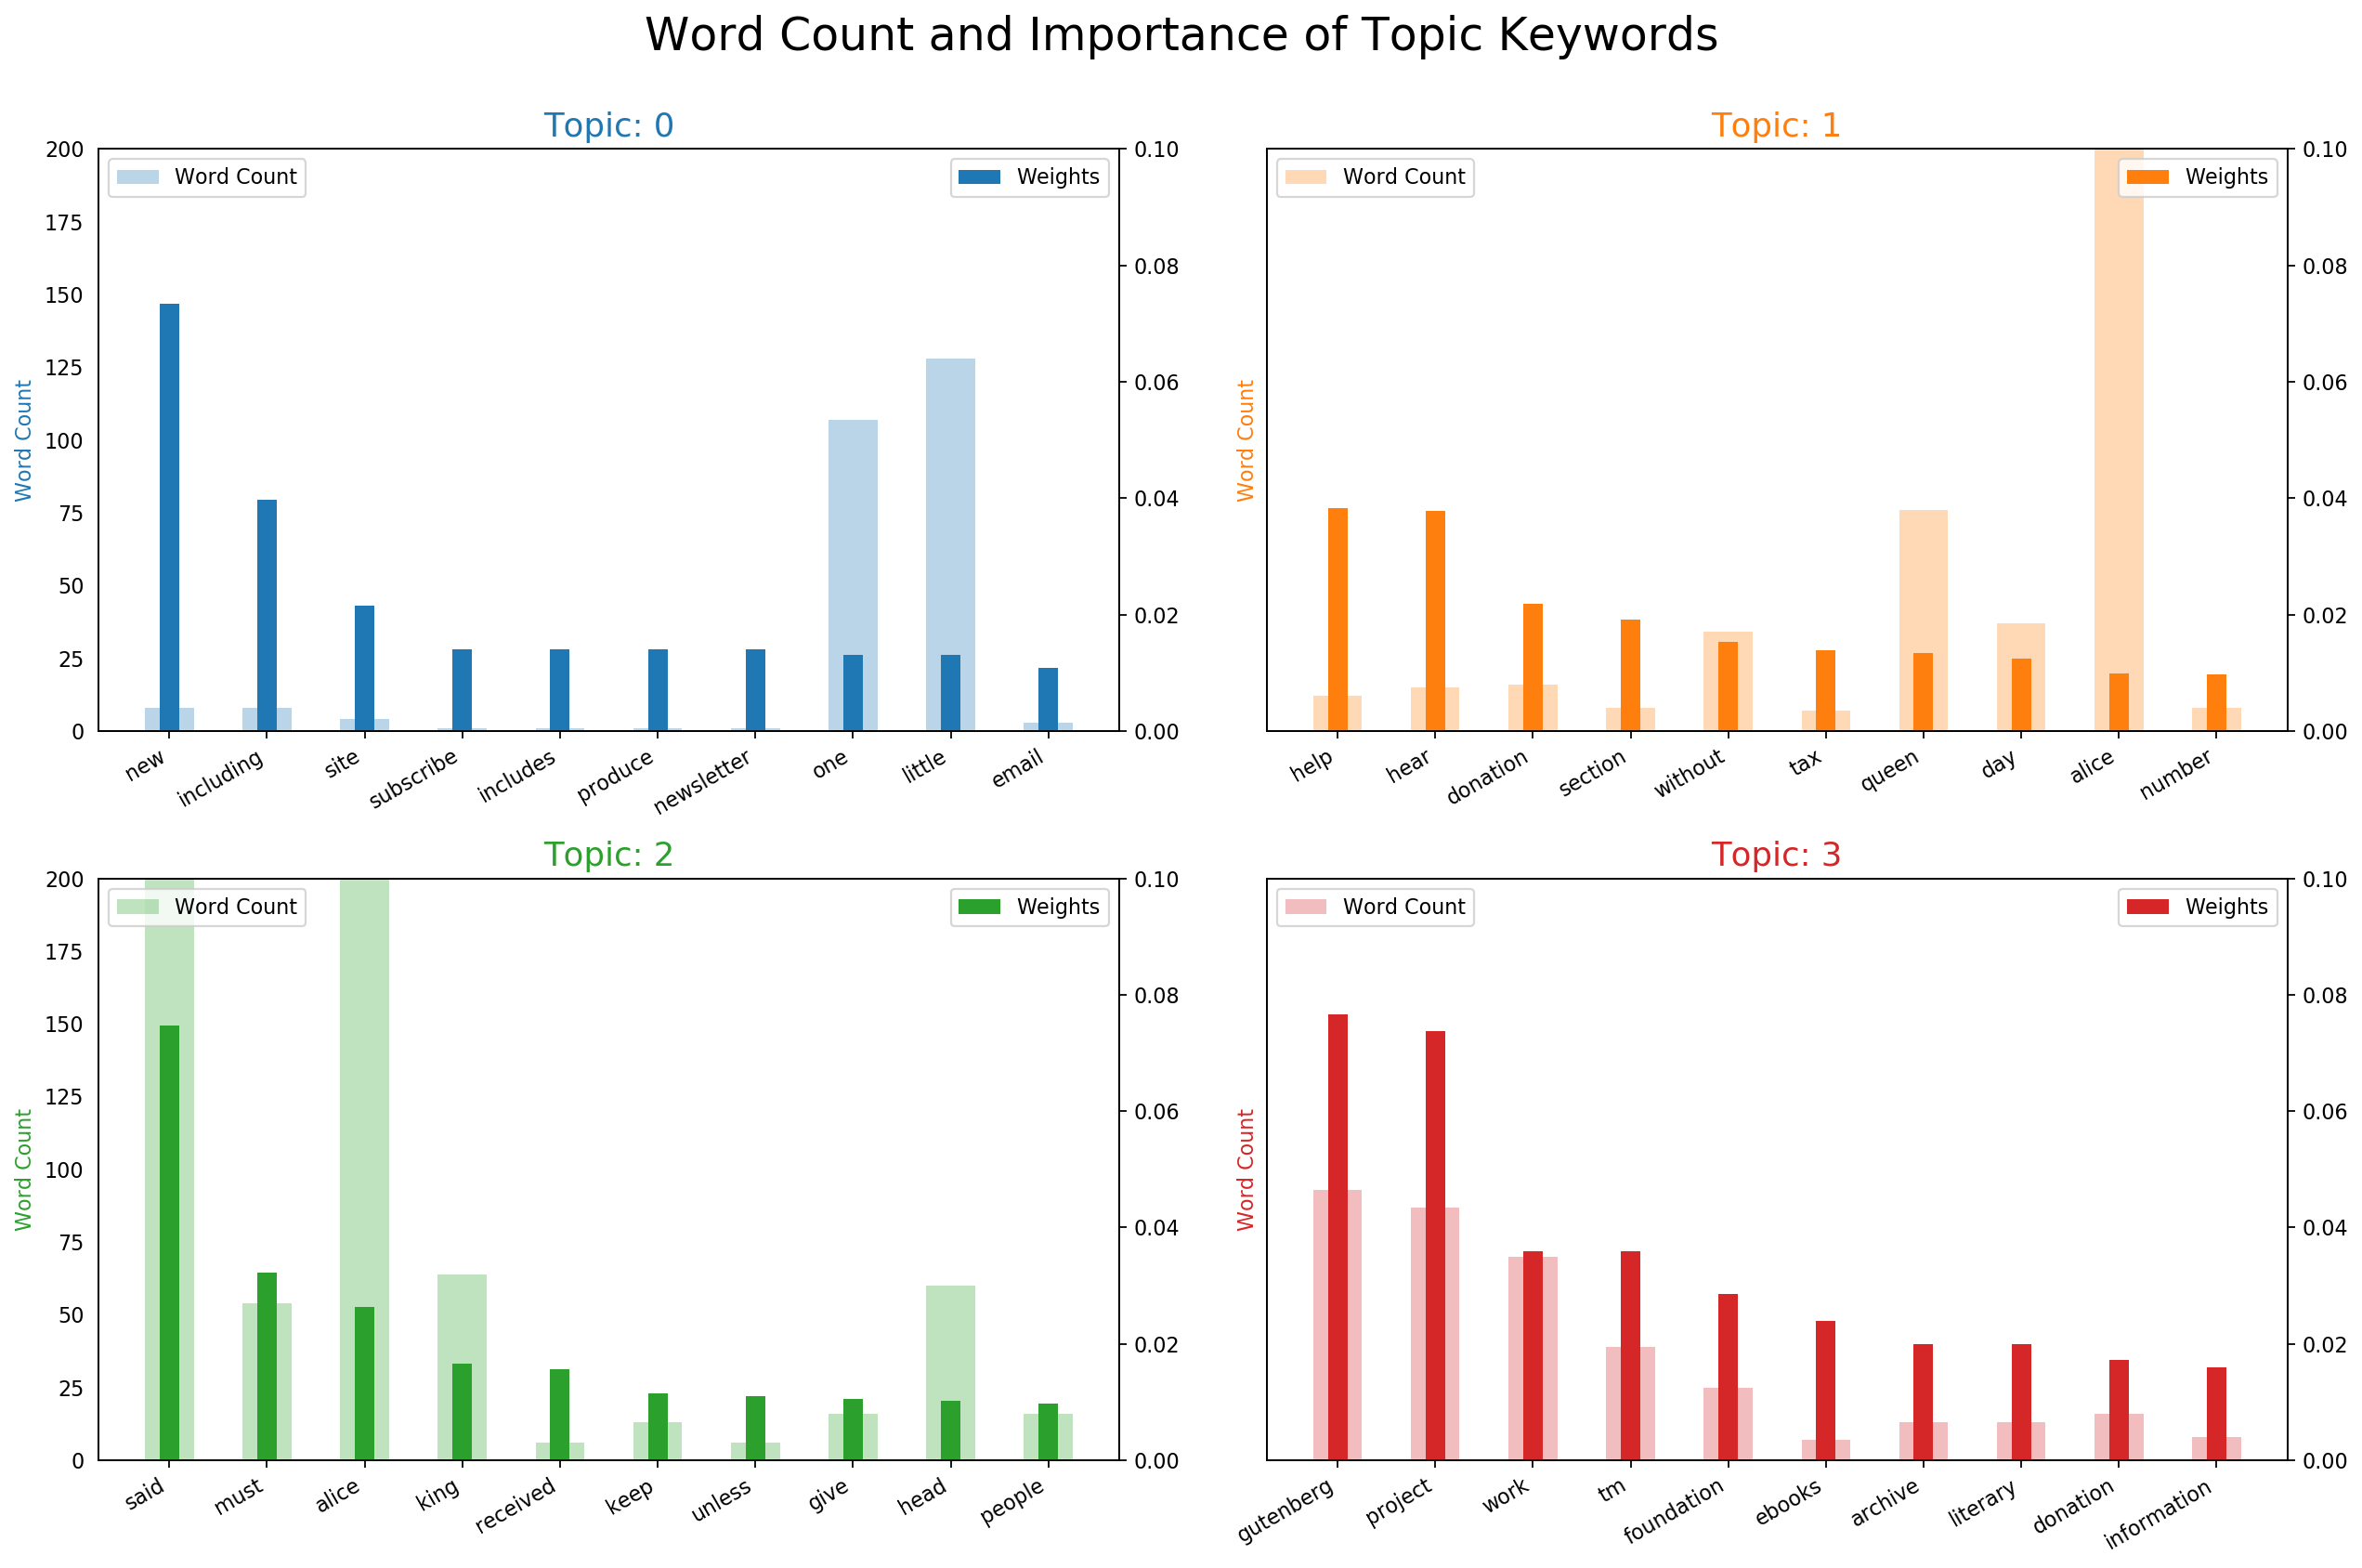

In [22]:
# Plot Word Count and Weights of Topic Keywords
import matplotlib.colors as mcolors

fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=out[i], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=out[i], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.10); ax.set_ylim(0, 200)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(out[i]['word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [23]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start=0, end=13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1 + start) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-1), 
                 fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

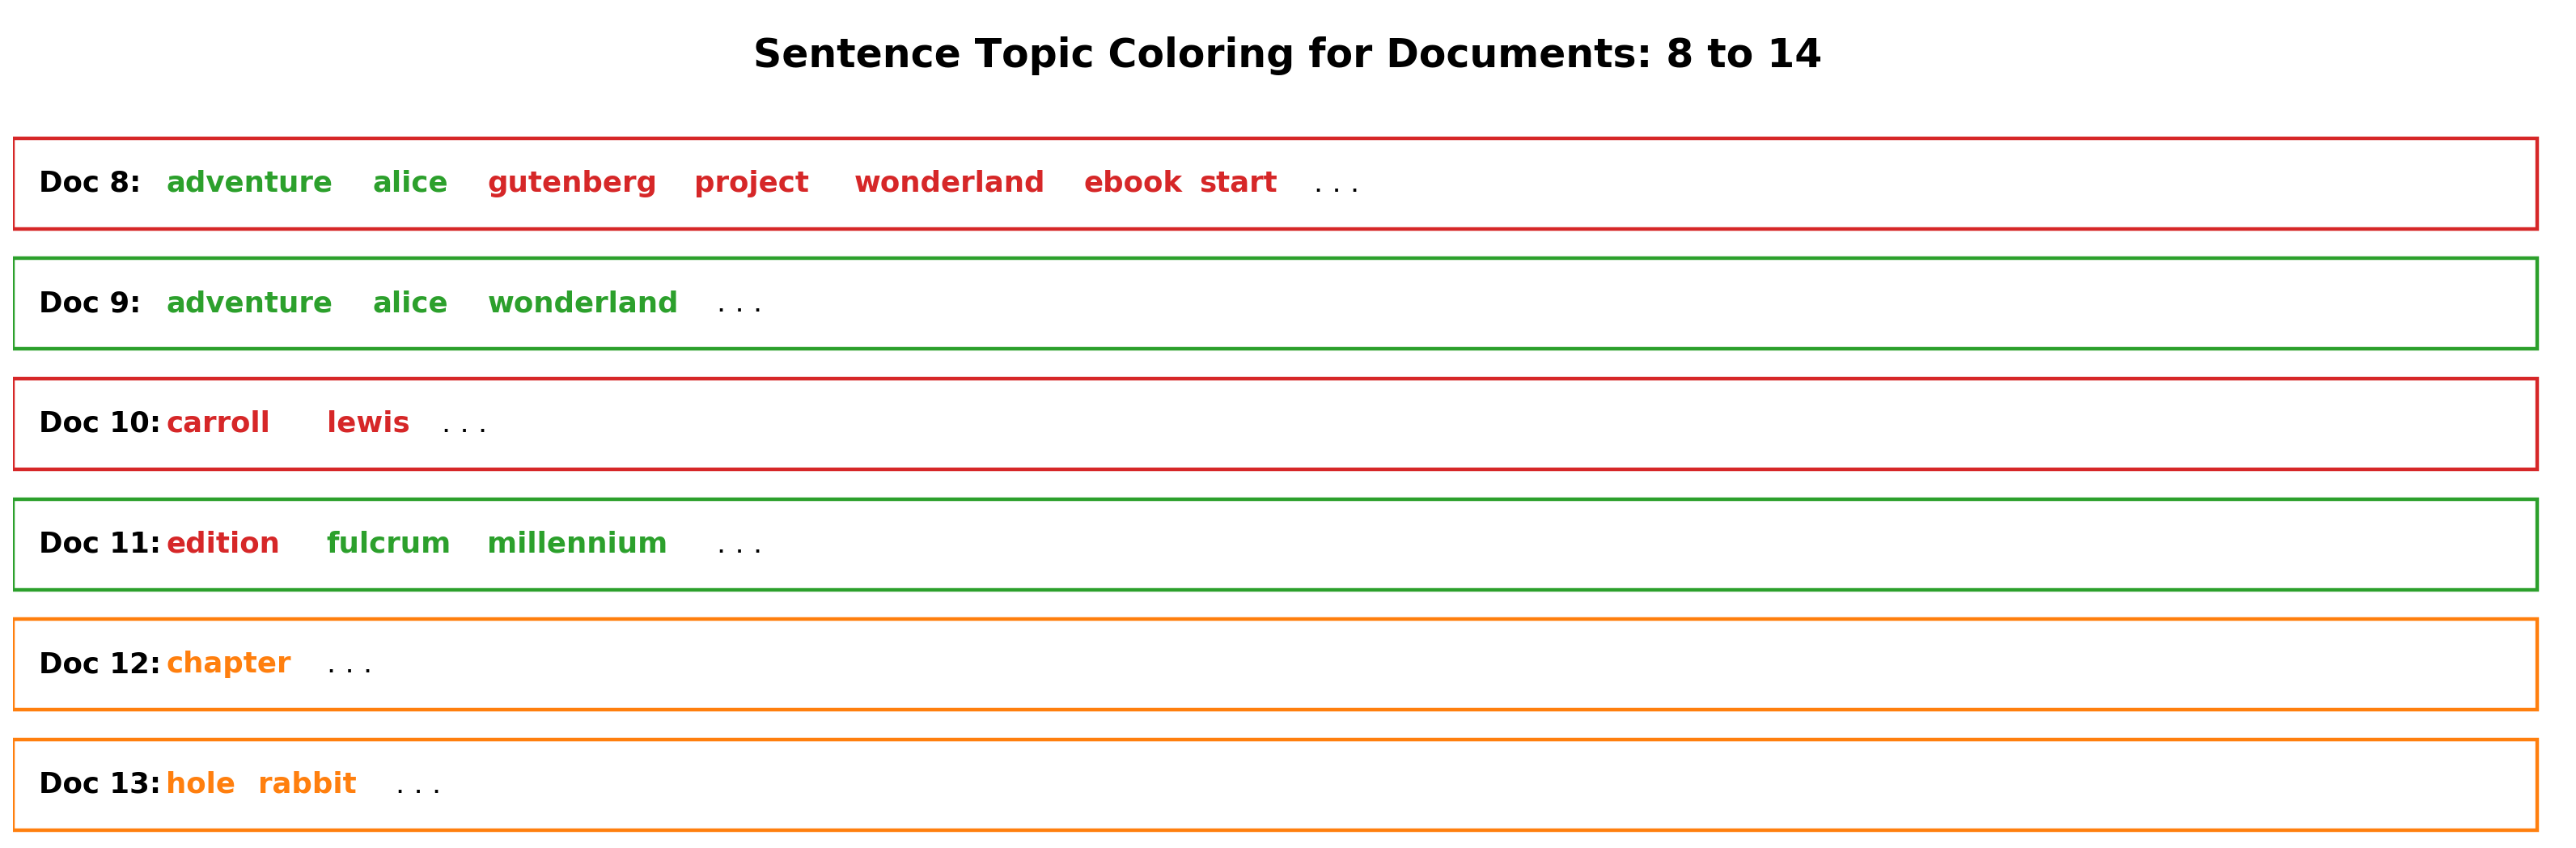

In [24]:
sentences_chart(start=8, end=15)  

For the final part we need an additional tool for visualization:

In [26]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\Gera\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.129063 -0.077834       1        1  28.378328
1      0.088756 -0.131942       2        1  27.428362
0      0.070715  0.229043       3        1  27.055820
3     -0.288534 -0.019267       4        1  17.137491, topic_info=     Category        Freq       Term       Total  loglift  logprob
185   Default  275.000000       said  275.000000  30.0000  30.0000
231   Default  259.000000        new  259.000000  29.0000  29.0000
3     Default  175.000000  gutenberg  175.000000  28.0000  28.0000
5     Default  168.000000    project  168.000000  27.0000  27.0000
85    Default  135.000000       hear  135.000000  26.0000  26.0000
...       ...         ...        ...         ...      ...      ...
2371   Topic4   28.912209        web   56.458614   1.0947  -4.3419
2257   Topic4   13.201465  trademark   17.739662   1.4684  -5.1259
2396   Topic4   38.490589   donation  124.406540   0.5908  -4.0558
2367   Topic4   14.796878       site   94.682274  -0.0922  -5.0118
2539   Topic4   13.634963      email   92.194618  -0.1474  -5.0935

[203 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2291      4  0.909884     access
923       1  0.997199      added
1849      2  0.076996      agree
1849      4  0.846960      agree
2282      1  0.147418  agreement
...     ...       ...        ...
214       1  0.984689       word
505       4  0.991149       work
1580      2  0.984842    writing
245       1  0.689758    written
245       2  0.295611    written

[254 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4])